# Where does science stand on the closed universe conundrum?

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# show result from all calculations of the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import sys, platform, os
from importlib import reload
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import scipy as sp
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM

In [2]:
# CAMB from pip install
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))


Using CAMB 1.0.7 installed at /opt/conda/envs/cosmos3/lib/python3.7/site-packages/camb


In [3]:
# Have you installed arviz?
# This is just for some easy of visualizations. Not strictly needed.
try:
    import arviz
except ImportError:
    import sys
    !{sys.executable} -m pip install arviz
    import arviz

In [4]:
try:
    import getdist
    ver = getdist.__version__
    if int(ver[0:1]) >= 1:
        pass
    else:
        !{sys.executable} -m pip install --upgrade getdist
        reload(getdist)
except ImportError:
    import sys 
    !{sys.executable} -m pip install --upgrade getdist
    import getdist

In [5]:
import pymc3 as pm
import theano.tensor as T
from theano.compile.ops import as_op

## Isotropic Universe(FRLW)

$$ \left( \frac{H}{H_0} \right) = \Omega_{r,0} a^{-4} + \Omega_{m,0} a^{-3} + \Omega_{k,0} a^{-2} + \Omega_{\Lambda,0}, \;\;\;\;\;\;\;\;\; a = \frac{1}{1+z}  $$
$a$ is the scale-factor of the universe, normalized such that $a = 1$ today.

$z$ is the redshift. 

$H = \frac{\dot a}{a}$ is the Hubble parameter.

$\Omega_i = \frac{8\pi G\rho_i}{3 H^2}$ is the density parameter for the i-th component of the universe.

### Cosmological Distances

$$d_L = \frac{d_M}{1+z}$$
$$d_M = \left\{ 
\begin{array} 
\frac{d_H}{\sqrt{\Omega_{k,0}}} \sinh \frac{d_C \sqrt{\Omega_{k,0}}}{d_H}  \\
 d_c   \\
\frac{d_H}{\sqrt{\Omega_{k,0}}} \sin \frac{d_C \sqrt{\Omega_{k,0}}}{d_H}  
\end{array}
\right.$$
$$d_C = d_H\int_0^z \frac{\mathrm{dz}}{\sqrt{\Omega_{r,0}a^{-4} + \Omega_{m,0}a^{-3} + + \Omega_{k,0}a^{-2}+ \Omega_{\Lambda,0}}}$$
$$d_H = \frac{c}{H_0} $$
Which are the **Luminosity**, **Transverse Comoving**, **Comoving** and **Hubble Distances** respectively.

In [6]:
# Generate Cosmologies
K = [0.0,0.9,-0.5]
cambPar = camb.CAMBparams()
rCosm = [ camb.get_background(
                cambPar.set_cosmology(
                    H0=67.66, ombh2=0.02234, omch2=0.11907, omk=kk))
         for kk in K]
H_0 = [rCosm[ii].h_of_z(0) for ii in np.arange(len(rCosm))]
z = np.linspace(0,100,1000)
Dist = [[H_0[ii]*rCosm[ii].angular_diameter_distance(z),
                    H_0[ii]*rCosm[ii].luminosity_distance(z),
                    H_0[ii]*rCosm[ii].comoving_radial_distance(z)]
                   for ii in np.arange(len(rCosm))]


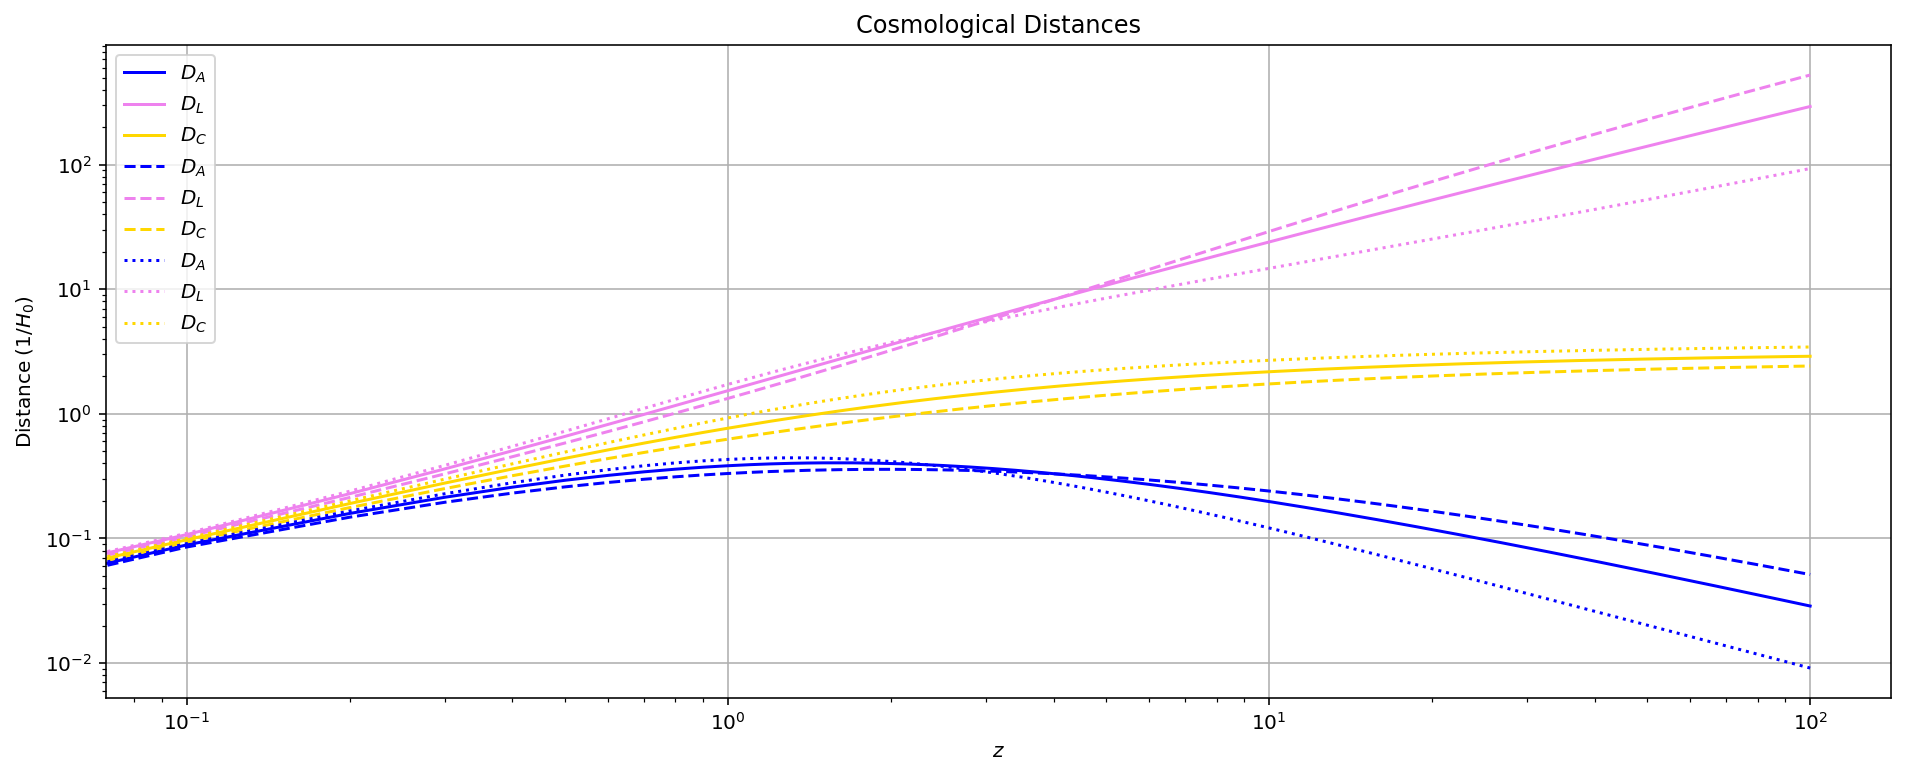

In [7]:
# Different Distances & Different Geometries
styles = ["solid", "dashed", "dotted"]
fig, ax = plt.subplots(figsize = (16,6))
for ii in np.arange(len(rCosm)):
    ax.plot(z, Dist[ii][0], color = "blue", label = r'$D_A$', linestyle = styles[ii] )
    ax.plot(z, Dist[ii][1], color = "violet", label = r'$D_L$', linestyle = styles[ii] )
    ax.plot(z, Dist[ii][2], color = "gold", label = r'$D_C$', linestyle = styles[ii] )
    ax.set_title("Cosmological Distances")
    ax.set_xlabel("$z$")
    ax.set_ylabel("$\mathrm{Distance}\; (1/H_0)$")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.legend()
plt.grid()
plt.show();

### Fates of Universes

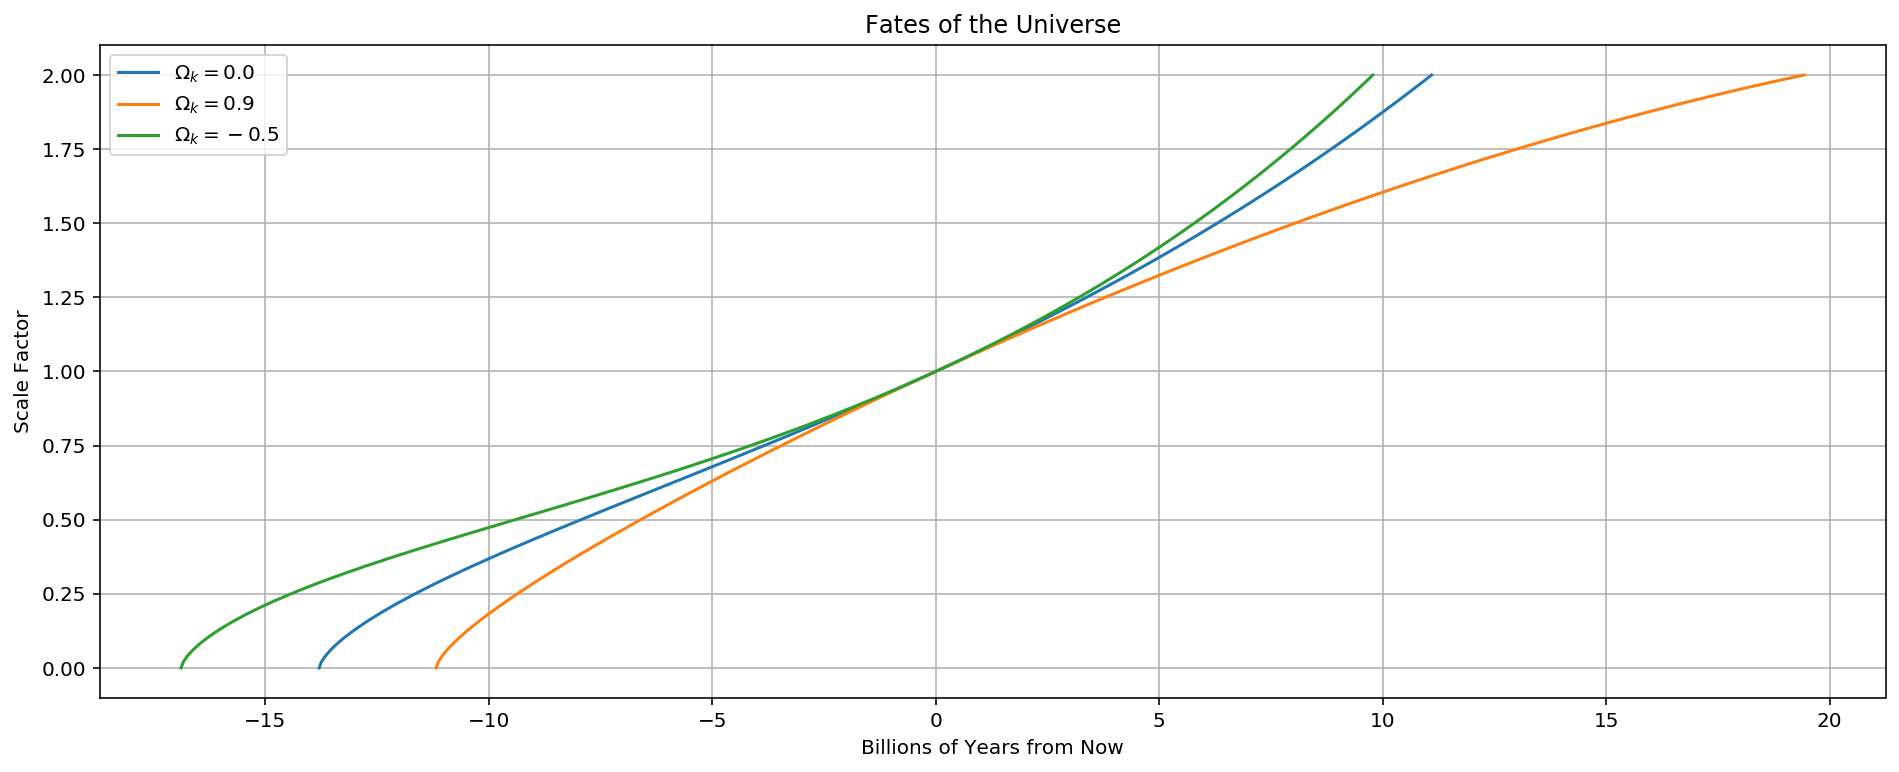

In [8]:
a = np.linspace(0,2,100)
age = [rCosm[ii].physical_time_a1_a2(0,1) for ii in np.arange(len(rCosm))]
tt = [ np.array(
                [rCosm[ii].physical_time_a1_a2(0,ai)
                 for ai in a]) - age[ii] 
      for ii in np.arange(len(K))]

fig = plt.subplots(figsize = (16,6))
for ii in [0,1,2]:
    plt.plot(tt[ii],a, label=r'$\Omega_k={}$'.format(K[ii]))
    plt.xlabel("Billions of Years from Now")
    plt.ylabel("Scale Factor")
    plt.title("Fates of the Universe")
    plt.legend()
plt.grid()
plt.show();

### Supernovas

We are going to use the UNION 2.1 dataset (http://supernova.lbl.gov/Union/) and some of he discussion will follow https://arxiv.org/abs/1401.4064 (Betole et Al). First we will discuss thing in a simpler context.

In [9]:
#Point syspath to find out lessons module
import os
import sys
sys.path.append('/home/cosmos/code/cosmos/lessons/')
from supernova import Supernova

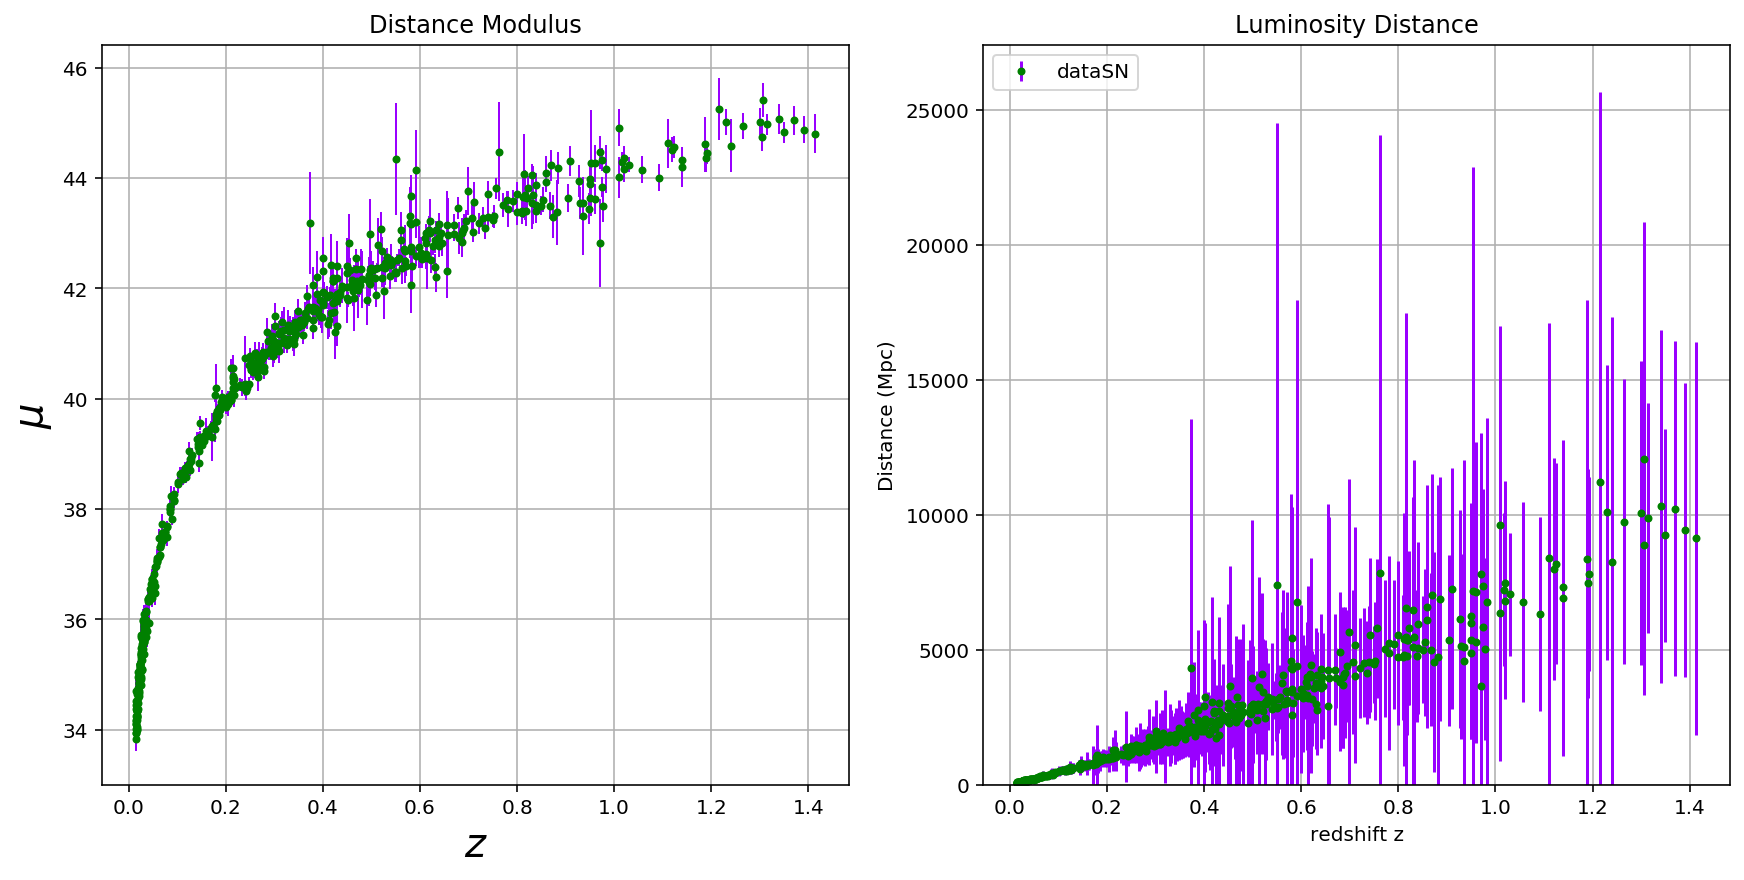

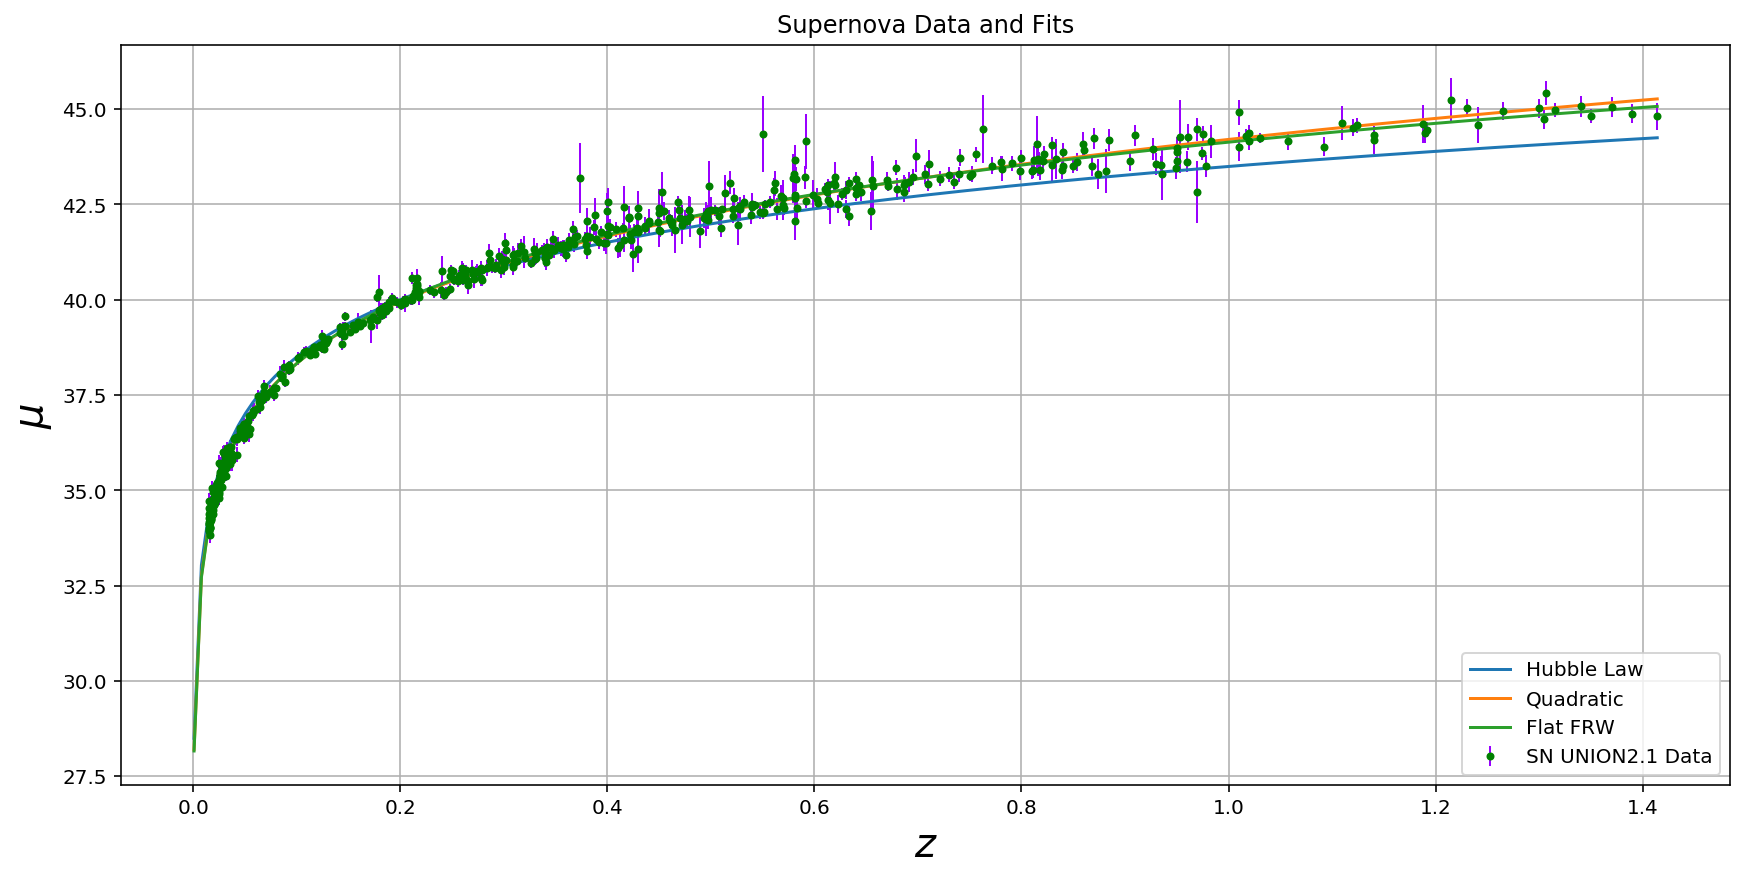

In [10]:
# Instantiate the Supernova class to fetch the data
SN = Supernova()
SN.plotDataToZ()
SN.plotFitZ();

In [11]:
print("flatFRW Model Parameters= ", 
      SN.fitDataMu(FIT = "FRW")[0].tolist())

flatFRW Model Parameters=  [70.00241539765383, 0.2776122297701926]


In [12]:
# CAMB luminosity function
def Luminosity_Distance(z, H0, O_m, O_L, O_k):
    hh = H0/100
    omch2 = O_m*hh**2
    omk = O_k
    O_L = 1-O_m
    cambPar = camb.CAMBparams()
    rCosm = camb.get_background(
        cambPar.set_cosmology(
            H0=H0, ombh2=0.022, omch2=omch2, omk=omk)
    )
    Dist = rCosm.luminosity_distance(z)    
    return Dist

In [13]:
H0=67.66
O_m = 0.3104
O_L = 0.6896 
h = H_0[0]

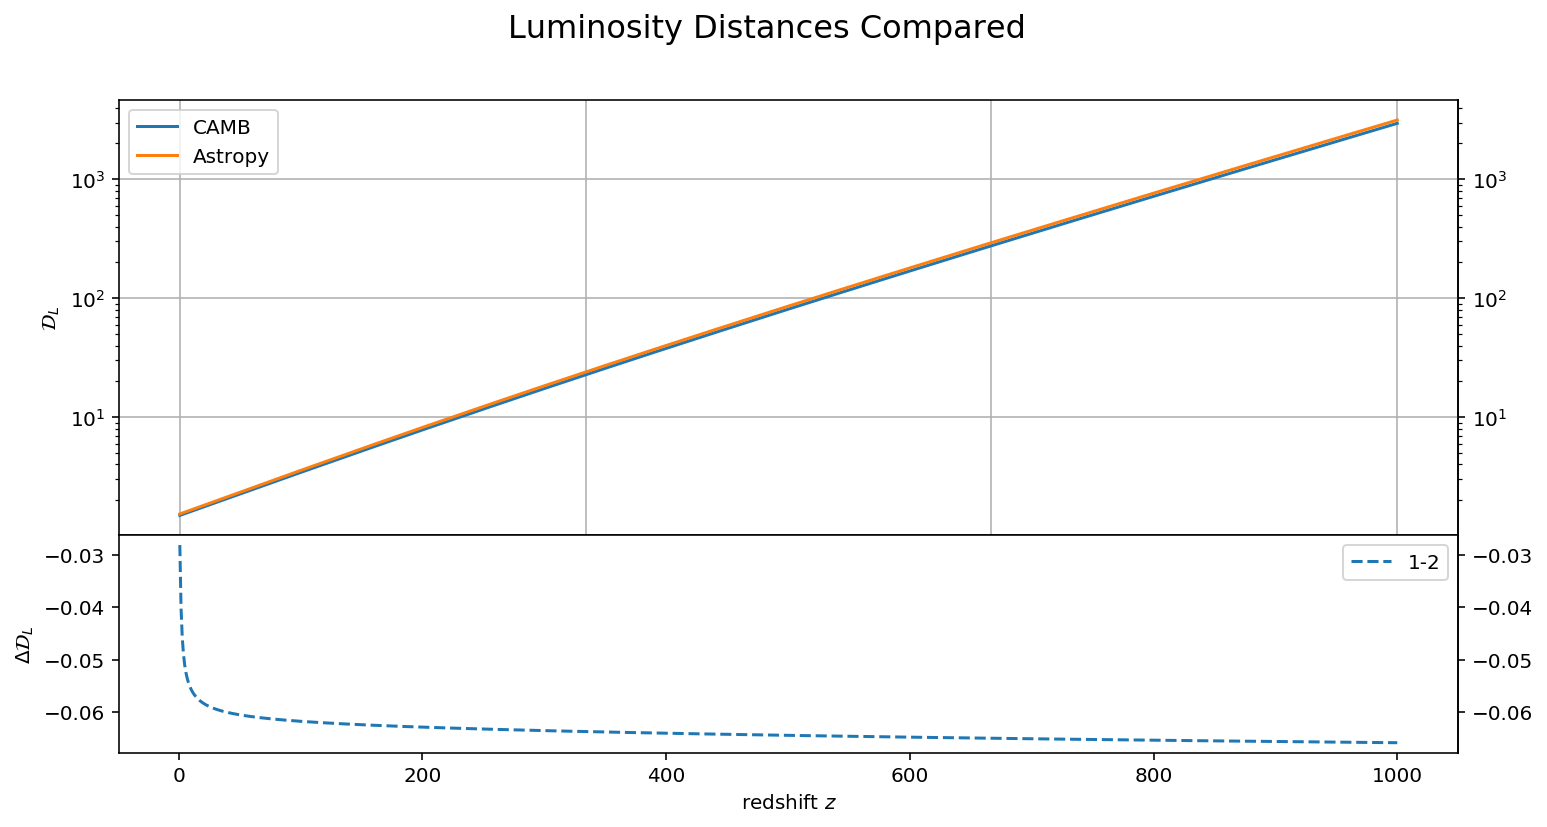

In [14]:

z = np.linspace(1,1000,1000)

cosmoF = FlatLambdaCDM(H0=H0, Om0=O_m)


DL1 = h*Luminosity_Distance(z,H0 = H0, O_m = O_m, O_L = O_L, O_k = 0)
DL2 = h*cosmoF.luminosity_distance(z).value
Delta_DL12 = (DL1-DL2)/DL1
fig = plt.figure()
gs = gridspec.GridSpec(3, 1, hspace = 0)
ax1 = fig.add_subplot(gs[:2, 0])
ax1.plot(z,DL1, label = "CAMB")
ax1.plot(z,DL2, label = "Astropy")
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.label_outer()
ax1.secondary_yaxis("right")
plt.grid()
plt.legend()
ax2 = fig.add_subplot(gs[2, 0])
ax2.plot(z,Delta_DL12, 
         linestyle = "dashed", label = "1-2")
fig.suptitle('Luminosity Distances Compared', fontsize=16)
ax1.set_ylabel(r"$\mathcal{D}_L$")
ax2.set_ylabel(r"$\Delta\mathcal{D}_L$")
ax2.set_xlabel(r"redshift $z$")
ax2.secondary_yaxis("right")
plt.legend()
plt.show();

In [15]:
z = np.linspace(0,10,100)
%timeit D_LsCAMB = [Luminosity_Distance(zz,H0 = H0, O_m = .3104, O_L = 0.6896, O_k = 0) for zz in z]
# The best options we have to calculate the distances
%timeit cosmoF.luminosity_distance(z).value


5.05 s ± 31.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
209 µs ± 2.53 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Flat Universe

We will choose the parameters $H_0$ and $\Omega_{m,0}$ to describe our model. The Dark Energy is simply given by $\Omega_{\Lambda,0}$.

The observable $\mu(z;\theta)$ is obtained from the luminosity distance, which in turn depends on our parameters. We car write our likelyhood as:

$$\mathcal{L} = P(\mu,z|H_0,\Omega_m) = \frac{1}{\sqrt{\mathrm{det}\;2\pi\Sigma}} \mathrm{exp} \left(-\frac{1}{2} \left[ \mu - \hat\mu(H_0,\Omega_m)\right]^T \Sigma^{-1} \left[ \mu - \hat\mu(H_0,\Omega_m)\right]  \right)$$

In [16]:
# Fetch Data
SN = np.genfromtxt("../DATA/SCPUnion2.1_mu_vs_z.txt")

order = SN[:, 1].argsort()
zs = SN[:, 1][order]
mods = SN[:, 2][order]


In [17]:
# Fetch the covariance matrix
Sigma = np.genfromtxt("../DATA/SCPUnion2.1_covmat_sys.txt")[order, :][:, order]
Sigma_no = np.genfromtxt("../DATA/SCPUnion2.1_covmat_nosys.txt")[order, :][:, order]

mod_errs = [np.sqrt(Sigma[i, i]) for i, _ in enumerate(Sigma)]
mu = mods

mod_errs_no = [np.sqrt(Sigma_no[i, i]) for i, _ in enumerate(Sigma_no)]


# Invert the covariance Matrix
invSigma = np.linalg.inv(Sigma)
invSigma_no = np.linalg.inv(Sigma_no)
# calculate the prefactor of the likelyhood Det(2 pi Sigma)
# The function return a signal and the log(det(a))
# underscores ignores the first element of the returning tuple
_, LogDetSigma = np.linalg.slogdet(2*np.pi*Sigma)
_, LogDetSigma_no = np.linalg.slogdet(2*np.pi*Sigma_no)

In [18]:
# These functios already incorporate the DATA
# They are function only of the parameters H0 and OmM
# We are using the distmod function from astropy
# no suffx indate covariance with no systematics considered.

def log_likelihood(H0 = 60, OmM = 0.3):
    cosmoF = FlatLambdaCDM(H0=H0, Om0=OmM)
    mods = cosmoF.distmod(zs).value
    Delta = mu - mods
    return -LogDetSigma/2. - Delta.dot(invSigma.dot(Delta))/2.

def log_likelihood_no(H0 = 60, OmM = 0.3):
    cosmoF = FlatLambdaCDM(H0=H0, Om0=OmM)
    mods = cosmoF.distmod(zs).value
    Delta = mu - mods
    return -LogDetSigma_no/2. - Delta.dot(invSigma_no.dot(Delta))/2.


In [19]:

# Prepare the LokLikelyHood to be a Theano Tensor of Random Variables
# It MUST return a NUMPY object
# The inputs will be Random Variables
@as_op(itypes=[T.dscalar, T.dscalar], otypes=[T.dscalar])
def logp(a,b):
    return np.array(log_likelihood(H0 = a, OmM = b))

@as_op(itypes=[T.dscalar, T.dscalar], otypes=[T.dscalar])
def logp_no(a,b):
    return np.array(log_likelihood_no(H0 = a, OmM = b))

# Our Model has Uniform Priors and a Potential only, since all the observed data
# is already contained in the functions.
# Inside the model we need to create a determinist random variable (energy) to use
# inside the potential
with pm.Model() as model:
    H0 = pm.Uniform('H0', 60, 80)
    OmM = pm.Uniform("OmM", 0, 1)
    
    energy = logp(H0, OmM)
    like = pm.Potential('energy', energy)

with pm.Model() as model_no:
    H0 = pm.Uniform('H0', 60, 80)
    OmM = pm.Uniform("OmM", 0, 1)
    
    energy = logp_no(H0, OmM)
    like = pm.Potential('energy', energy)  

In [20]:
# Our likelyhood is not a native Theano object, there is no known Gradient 
# So only MonteCarlo-Hastings and Slice will work as sampling methods.
# NOTE: We can implement a gradient method later
with model:
    step = pm.Metropolis()
    trace = pm.sample(5000, step=step, cores = 7)

with model_no:
    step = pm.Metropolis()
    trace_no = pm.sample(5000, step=step, cores = 7)

Multiprocess sampling (7 chains in 7 jobs)
CompoundStep
>Metropolis: [OmM]
>Metropolis: [H0]
Sampling 7 chains: 100%|██████████| 38500/38500 [07:20<00:00, 87.39draws/s] 
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (7 chains in 7 jobs)
CompoundStep
>Metropolis: [OmM]
>Metropolis: [H0]
Sampling 7 chains: 100%|██████████| 38500/38500 [07:35<00:00, 84.46draws/s] 
The number of effective samples is smaller than 10% for some parameters.


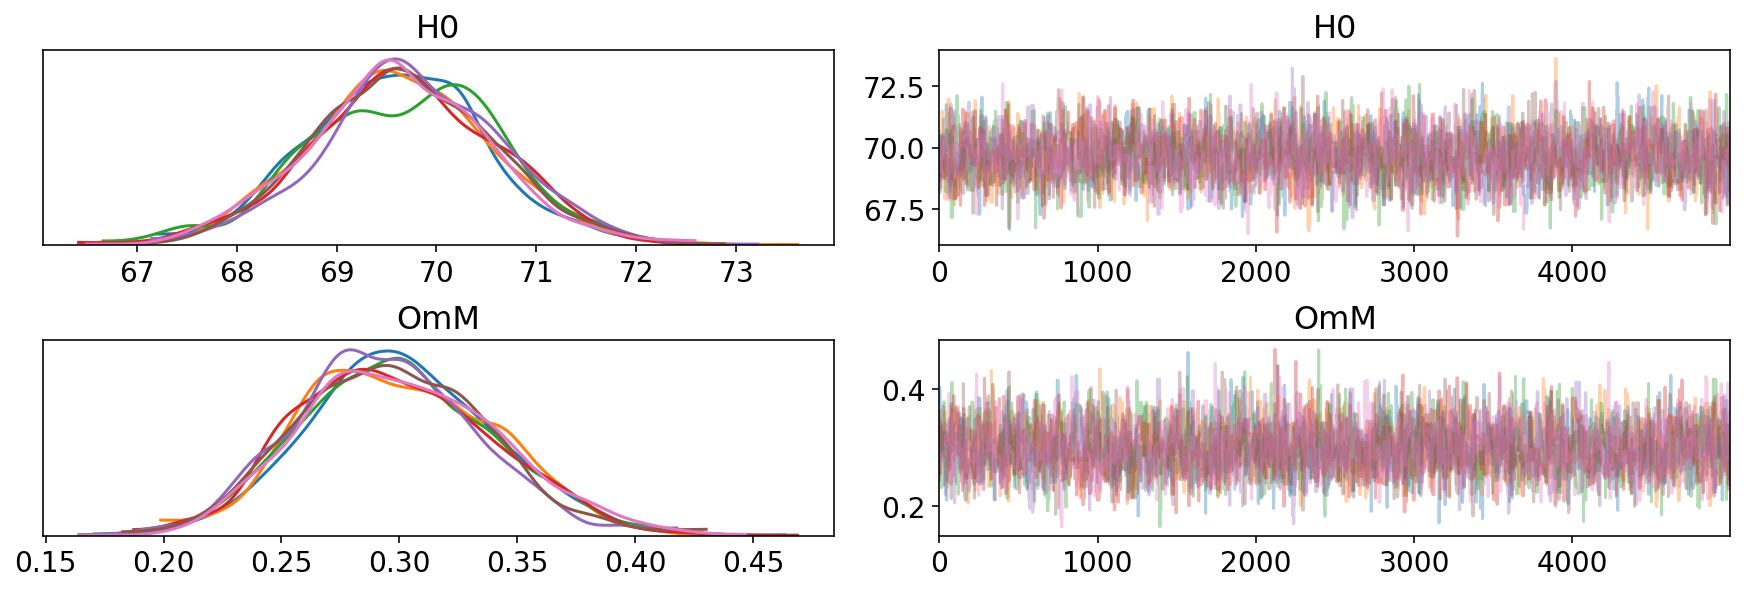

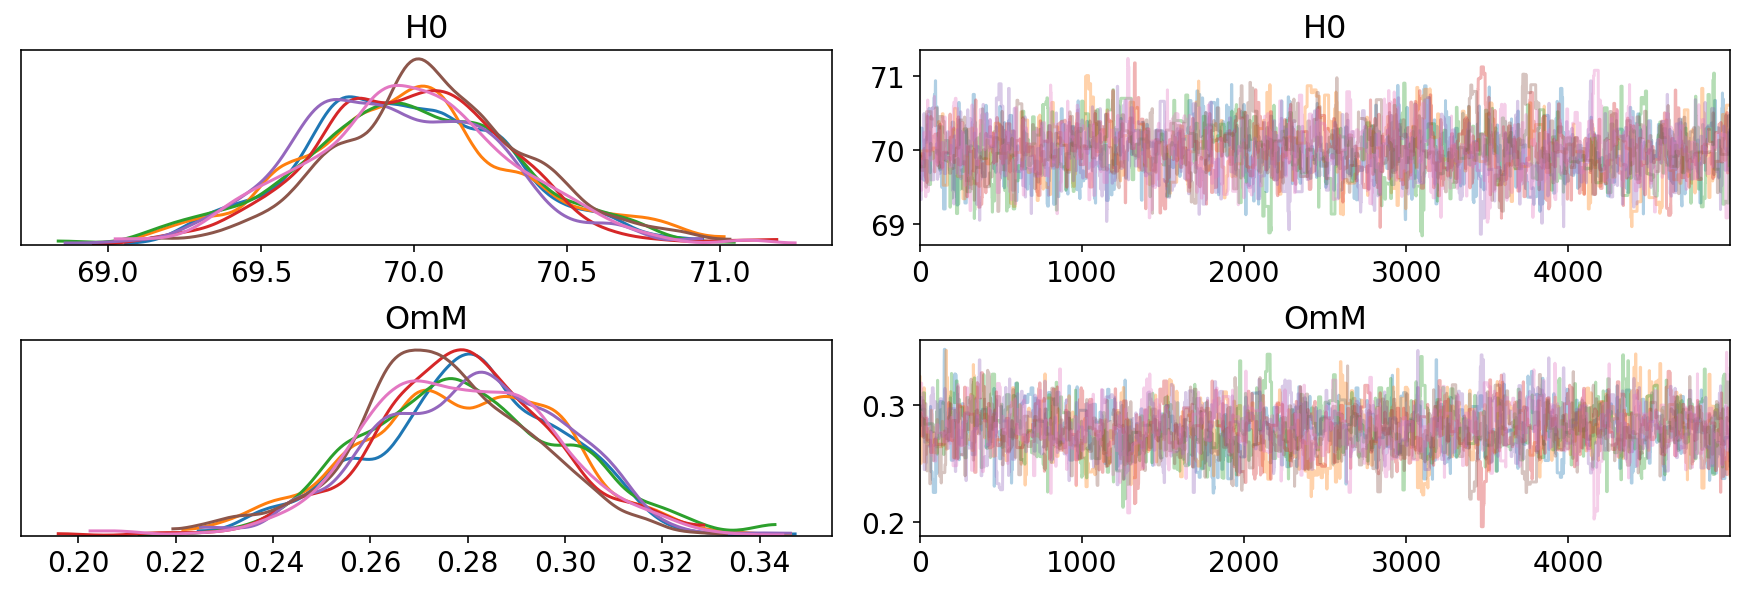

In [21]:
az.plot_trace(trace);
az.plot_trace(trace_no);

In [22]:
az.summary(trace)
az.summary(trace_no)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
H0,69.667,0.903,68.001,71.402,0.019,0.013,2297.0,2297.0,2294.0,3649.0,1.0
OmM,0.299,0.040,0.227,0.375,0.001,0.001,2377.0,2356.0,2413.0,3885.0,1.0


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
H0,69.990,0.339,69.353,70.659,0.011,0.008,890.0,890.0,884.0,1097.0,1.01
OmM,0.279,0.020,0.242,0.315,0.001,0.000,944.0,944.0,948.0,1164.0,1.01


In [24]:
from getdist import plots, MCSamples

In [25]:
# O_L is not an independent parameter
O_L = 1 - trace["OmM"]
O_L_no = 1 - trace_no["OmM"]

Removed 0.3 as burn in
Removed 0.3 as burn in


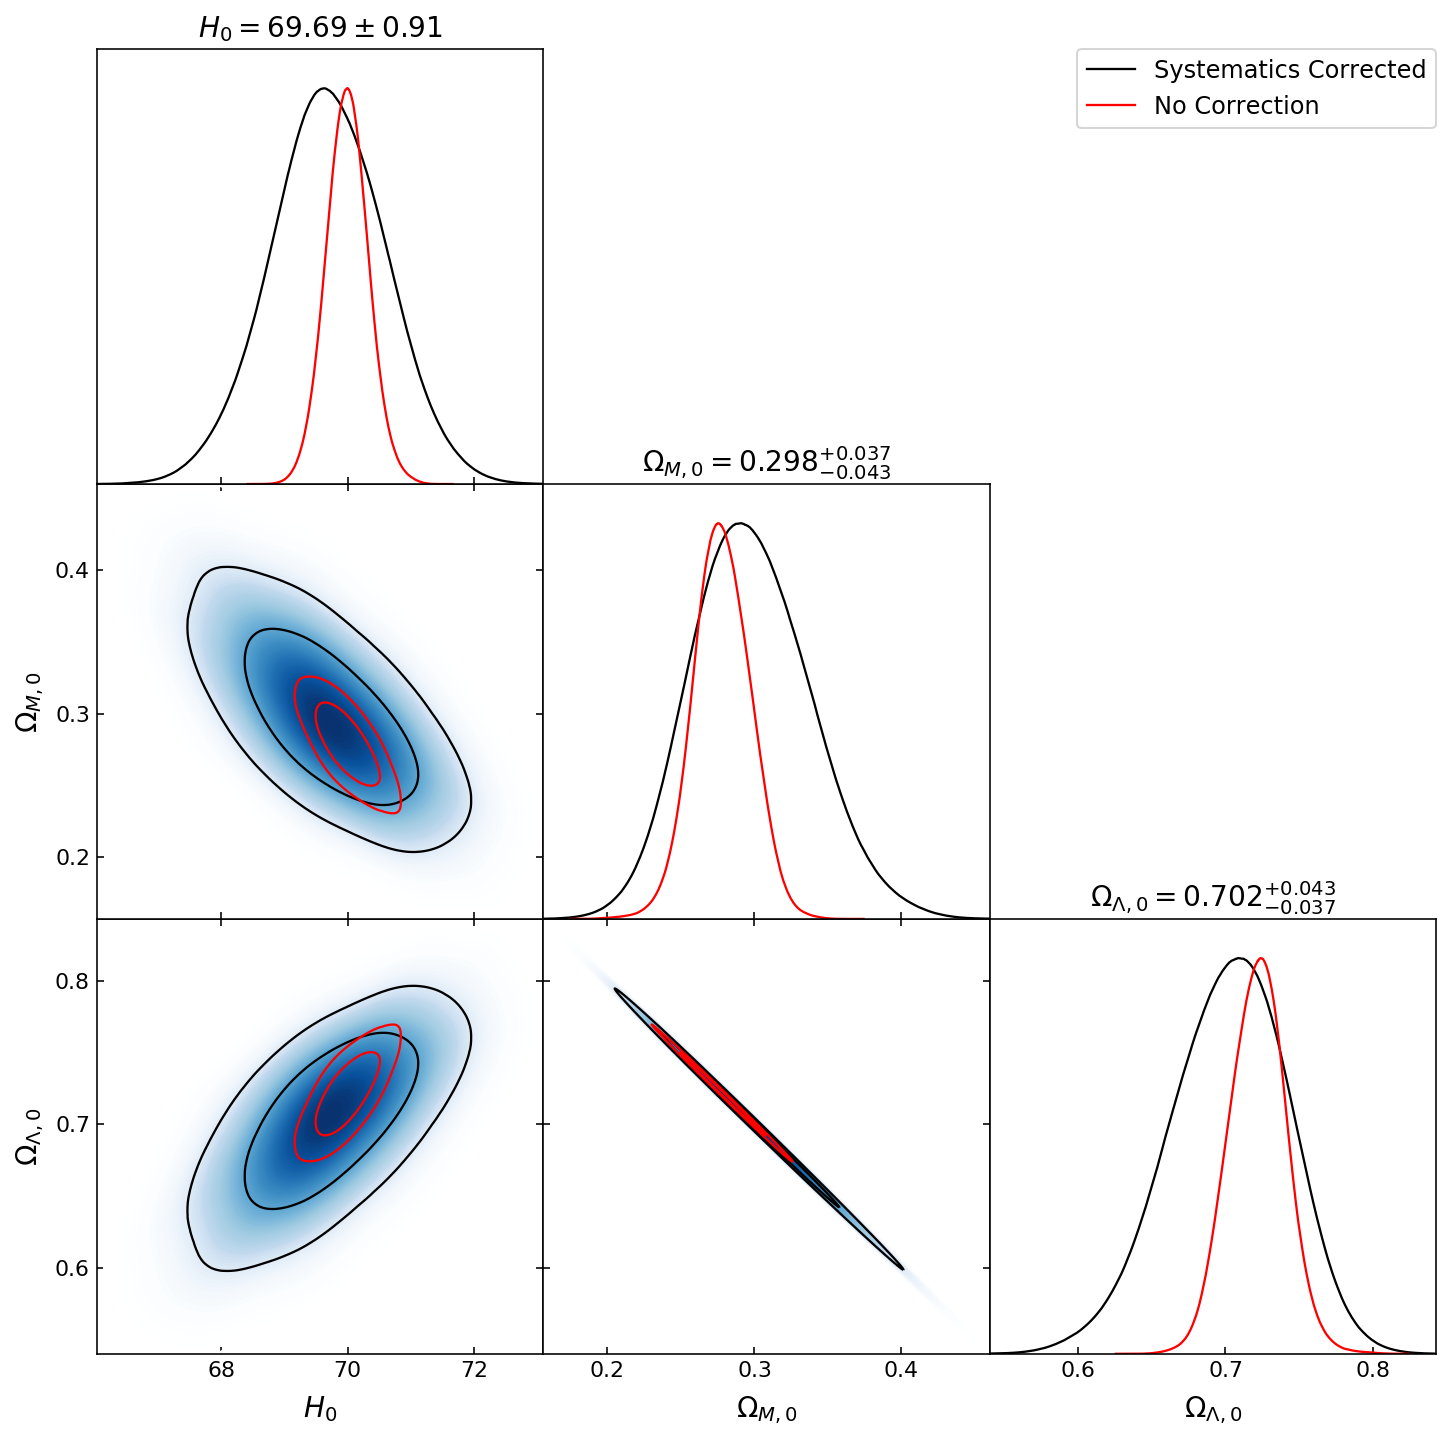

In [26]:
# extract the traces and plot the results
pymc_trace = np.asarray([trace['H0'][:], trace['OmM'][:],  O_L]).T
pymc_trace_no = np.asarray([trace_no['H0'][:], trace_no['OmM'][:],  O_L_no]).T
names = ["H0", "OmM", "O_L"]
labels =  [r'H_0', r'\Omega_{M,0}', r'\Omega_{\Lambda,0}']
samples = MCSamples(samples=pymc_trace, 
                    names = names, 
                    labels = labels, 
                    label = "Systematics Corrected", 
                    settings={'ignore_rows':0.3})
samples_no = MCSamples(samples=pymc_trace_no,
                       names = names,
                       labels = labels,
                       label = "No Correction",
                       settings={'ignore_rows':0.3})
# Triangle plot
g = plots.get_subplot_plotter(width_inch=12)
g.settings.title_limit_fontsize = 14
g.triangle_plot([samples,samples_no],
                shaded=True,
                title_limit=1, # first title limit (for 1D plots) is 68% by default
                markers={'alpha':27})
# g.export("bayes.png") #Save?

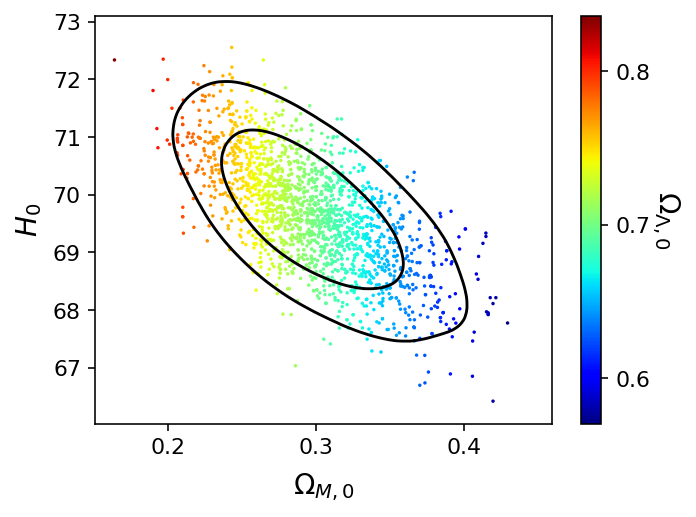

In [27]:
# 2D scatter (3D) plot
g = plots.get_single_plotter(width_inch=5)
g.plot_3d([samples,samples], ["OmM", "H0","O_L"])

In [28]:
# Credible Interval
z_range = np.linspace(0.01 ,1.5*max(zs),50)
traceH =trace["H0"]
traceO =trace["OmM"]
# Sample de posterior with chains and calculate statistisc for percentiles
mu_hat = np.asarray([ FlatLambdaCDM(H0=x[0], Om0=x[1]).distmod(z_range).value for x in zip(traceH, traceO)])
bounds = np.percentile(mu_hat, 100 * sp.stats.norm.cdf([-1.65, 1.65]), axis = 0)

## Best Fit 
H0fit = trace["H0"].mean()
OmMfit = trace["OmM"].mean()
mu_hat_best = FlatLambdaCDM(H0=H0fit, Om0=OmMfit).distmod(z_range).value

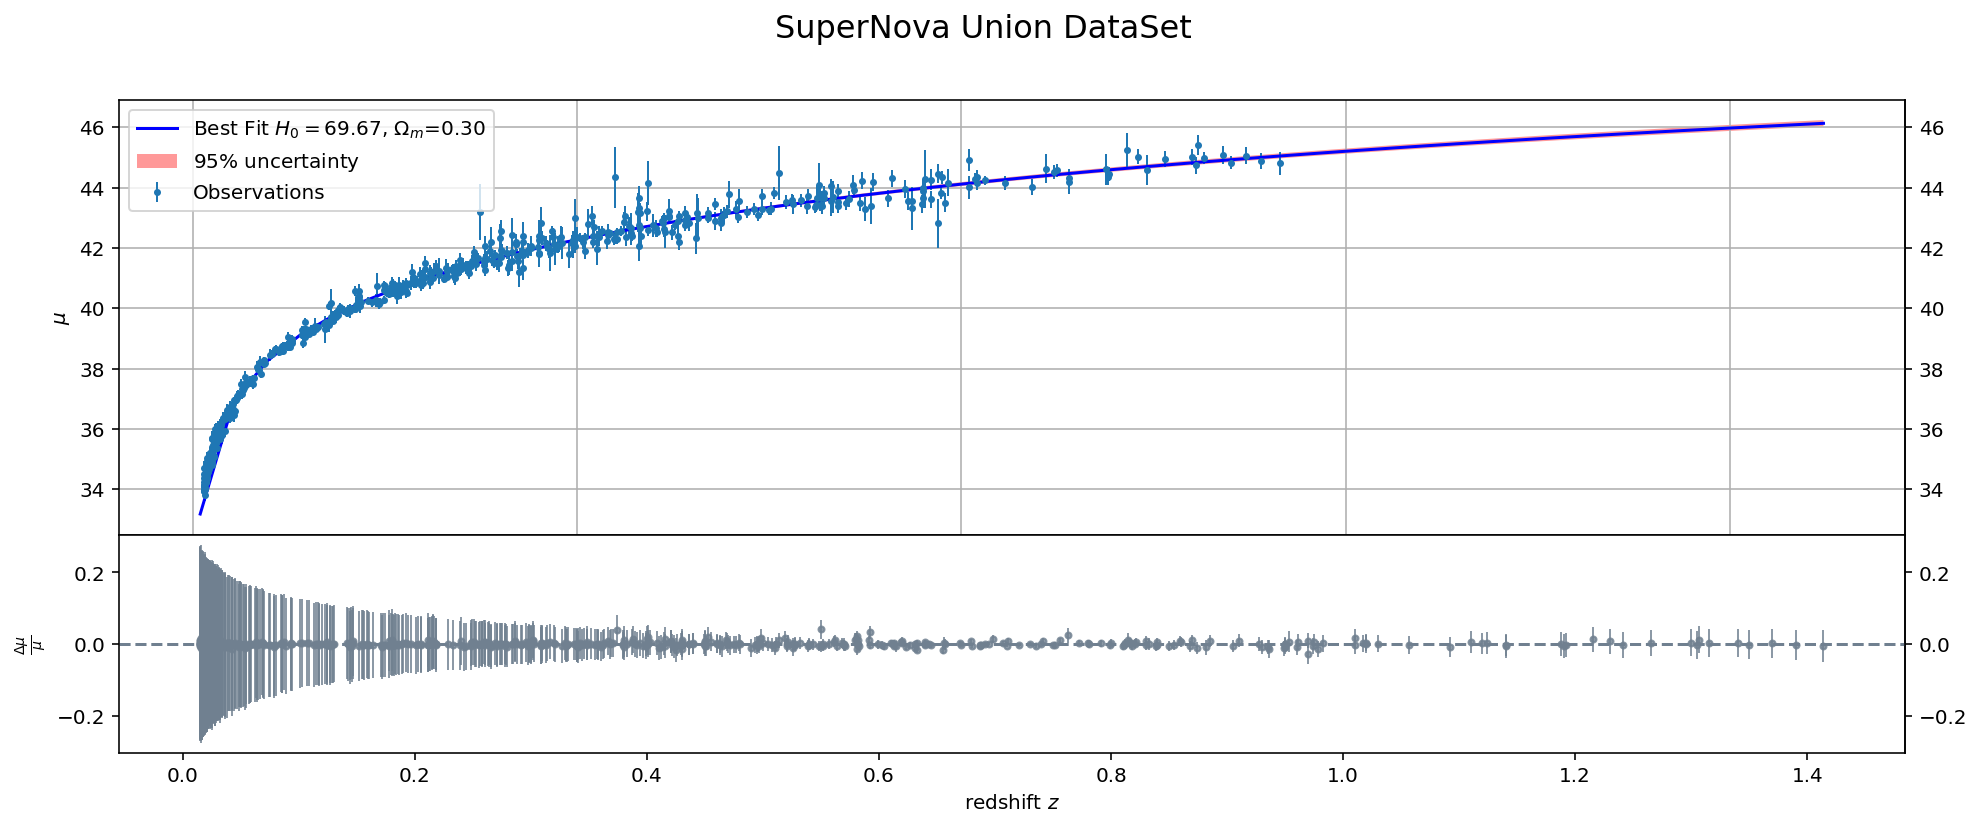

In [30]:
# This is for the error Bars: Bounds calculated in the same range of data
# predictions for the same z as the data
# Error bars from standard propagation
mu_hat_loc = FlatLambdaCDM(H0=H0fit, Om0=OmMfit).distmod(zs).value
boundsPanel = np.percentile(mu_hat_loc, 100 * sp.stats.norm.cdf(1), axis = 0)
delta = np.asarray((mu - mu_hat_loc)/mu)
error_Panel = delta * np.sqrt(
    (mod_errs/mu)**2 +
    ((np.sqrt(np.asarray(mod_errs)**2 +(mu_hat_loc-boundsPanel)**2))/(mu-mu_hat_loc))**2)

fig = plt.figure(figsize=(16,6))
gs = gridspec.GridSpec(3, 1, hspace = 0)
ax1 = fig.add_subplot(gs[:2, 0])
ax1.errorbar(zs, mu, yerr = mod_errs, fmt = ".", label = "Observations", ms = 5, lw = 1)
ax1.plot(z_range, mu_hat_best, 
         label = r"Best Fit $H_0=${h0:.2f}, $\Omega_m$={om:.2f}".format(h0 = trace["H0"].mean(), 
                                                                        om = trace["OmM"].mean()), 
         c = "blue")
ax1.fill_between(z_range, bounds[0, :], bounds[-1, :], 
                 label=r"$95\%$ uncertainty", fc="red", alpha=0.4)
ax1.set_ylabel(r"$\mu$")
ax1.label_outer()
ax1.secondary_yaxis("right")
plt.grid()
plt.legend()
ax2 = fig.add_subplot(gs[2, 0])
fig.suptitle('SuperNova Union DataSet', fontsize=16)
ax2.errorbar(zs, delta, yerr = error_Panel, 
             label = "Deviation", 
             c = "slategray", 
             fmt=".", 
             lw = 1, 
             alpha = 0.8)
ax2.axhline(0, linestyle = "dashed", c = "slategray")
ax2.set_ylabel(r"$\frac{\Delta\mu}{\mu}$")
ax2.set_xlabel(r"redshift $z$")
ax2.secondary_yaxis("right")
#plt.legend()
#plt.savefig('NiceSupernova.png')
plt.show();

## Curved Universe

## Bayesian Selection: Flat or Curved for the best fit?

## Nuisance Parameters

## JLA full analysis with PYMC3

## JLA full analysis with Montepython

## First Cobaya Analysis